In [74]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve
import statsmodels.api as sm
from math import log,sqrt,exp
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from riskmgmt import *

Problem 1

In [75]:
current_date = dt.datetime(2023, 3, 3)
expiration_date = dt.datetime(2023, 3, 17)
time_to_maturity = (expiration_date - current_date).days
print("Time to maturity:", time_to_maturity, "calendar days")

Time to maturity: 14 calendar days


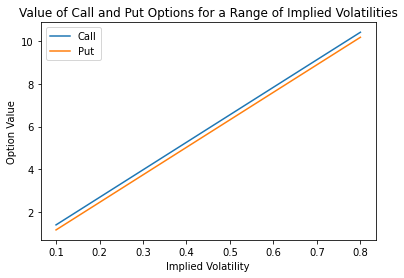

In [76]:
# Inputs
S = 165  # current stock price
K0 = 165
K_call = 145  # strike price for call option
K_put = 185 # strike price for put option
r = 0.0425  # risk-free rate
q = 0.0053  # continuously compounded coupon
T = time_to_maturity/ 365  # time to maturity in years
sigma_range = np.linspace(0.1, 0.8, 50)  # range of implied volatilities

# Black-Scholes formula
def black_scholes(S, K, T, r, q, sigma, option='call'):
    d1 = (np.log(S / K) + (r - q + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option == 'call':
        value = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option == 'put':
        value = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

    return value

# Calculate values for call and put options
call_values = [black_scholes(S, K0, T, r, q, sigma, 'call') for sigma in sigma_range]
put_values = [black_scholes(S, K0, T, r, q, sigma, 'put') for sigma in sigma_range]

# Plot the results
plt.plot(sigma_range, call_values, label='Call')
plt.plot(sigma_range, put_values, label='Put')
plt.legend()
plt.xlabel('Implied Volatility')
plt.ylabel('Option Value')
plt.title('Value of Call and Put Options for a Range of Implied Volatilities')
plt.show()


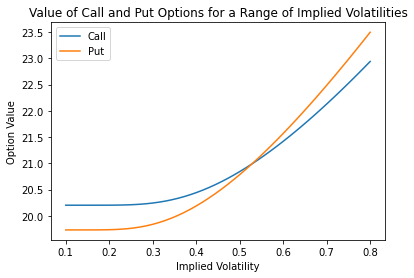

In [77]:
# Calculate values for call and put options
call_values = [black_scholes(S, K_call, T, r, q, sigma, 'call') for sigma in sigma_range]
put_values = [black_scholes(S, K_put, T, r, q, sigma, 'put') for sigma in sigma_range]

# Plot the results
plt.plot(sigma_range, call_values, label='Call')
plt.plot(sigma_range, put_values, label='Put')
plt.legend()
plt.xlabel('Implied Volatility')
plt.ylabel('Option Value')
plt.title('Value of Call and Put Options for a Range of Implied Volatilities')
plt.show()

Problem 2

In [78]:
S =151.03
r = 0.0425
q = 0.0053
aapl_options = pd.read_csv("AAPL_Options.csv")
curdate= dt.datetime(2023,3,3)
aapl_options['Expiration']=aapl_options['Expiration'].astype("datetime64[ns]")
aapl_options['T'] = aapl_options['Expiration'].apply(lambda x: round((x-curdate).days/365,6))
aapl_options['Type'] = aapl_options['Type'].apply(lambda x: bool(x=="Call"))

In [79]:
# Generalized Black Scholes Merton formula
def gbsm(S,K,T,r,q,ivol,call=True):
    d1 = (log(S/K)+(q+ivol**2/2)*T)/(ivol*sqrt(T))
    d2 = d1 - ivol*sqrt(T)
    if call:
        return S * exp((q-r)*T) * norm(0,1).cdf(d1) - K*exp(-r*T)* norm(0,1).cdf(d2)
    else:
        return K*exp(-r*T)* norm(0,1).cdf(-d2) - S * exp((q-r)*T) * norm(0,1).cdf(-d1)

In [80]:
# Calculate Inmplied Volatility
def implied_vol(S,K,T,r,q,call,value,initvol):
    def sol_vol(x,S,K,T,r,q,call,value):
        return gbsm(S,K,T,r,q,x,call=call)-value
    vol = fsolve(sol_vol,initvol,args=(S,K,T,r,q,call,value))
    return vol[0]

In [81]:
def row_fun(row,S,r,q):
    vol = implied_vol(S,row['Strike'],row['T'],r,q,row['Type'],row['Last Price'],0.2)
    return vol
aapl_options['Implied Vol'] = aapl_options.apply(row_fun,args=(S,r,round(r-q,4)),axis=1)

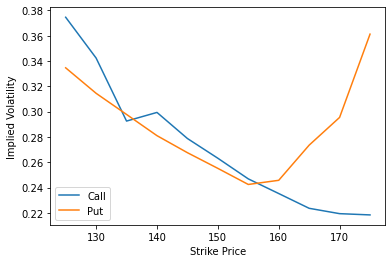

In [82]:
# Plot the results
aapl_call = aapl_options[aapl_options['Type']==True]
aapl_put = aapl_options[aapl_options['Type']==False]
plt.plot(aapl_call['Strike'],aapl_call['Implied Vol'],label="Call")
plt.plot(aapl_put['Strike'],aapl_put['Implied Vol'],label="Put")
plt.ylabel("Implied Volatility")
plt.xlabel("Strike Price")
plt.legend()

Problem 3

In [83]:
S = 151.03
r = 0.0425
q = 0.0053
portfolio = pd.read_csv("Problem3.csv")
curdate = dt.datetime(2023,3,3)
portfolio['ExpirationDate']=portfolio['ExpirationDate'].astype("datetime64[ns]")
portfolio['T'] = portfolio['ExpirationDate'].apply(lambda x: round((x-curdate).days/365,6))
portfolio['OptionType'] = portfolio['OptionType'].apply(lambda x: bool(x=="Call") if pd.notna(x) else x)

In [84]:
# Caculate implied volatility
def row_fun_port(row,S,r,q):
    vol = implied_vol(S,row['Strike'],row['T'],r,q,row['OptionType'],row['CurrentPrice'],0.2)
    return vol
portfolio['Implied Vol'] = portfolio[portfolio['Type']=='Option'].apply(row_fun_port,args=(S,r,round(r-q,4)),axis=1)

# Calculate value for each option given the underlying
def value_cal(row,S,r,q,daysahead):
    if row['Type'] == 'Stock':
        return S
    else:
        return gbsm(S,row['Strike'],row['T']-daysahead/365,r,q,row['Implied Vol'],row['OptionType'])*row['Holding']

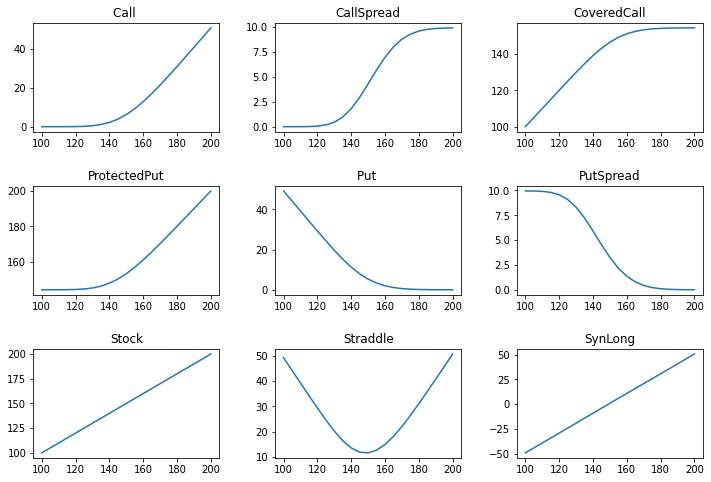

In [85]:
underlying_list = np.linspace(100,200,num=21).tolist()
portfolio_values = pd.DataFrame(portfolio['Portfolio'])
for S in underlying_list:
    portfolio_values[S]=portfolio.apply(value_cal,args=(S,r,round(r-q,4),0),axis=1)
# Portfolio values under the range
portfolio_range = portfolio_values.groupby('Portfolio').sum().T
# Plot the shape for each portfolio
fig, axs = plt.subplots(nrows=3, ncols=3,figsize=(12,8))
for i in range(len(portfolio_range.columns)):
    x_ax = i // 3
    y_ax = i % 3
    portfolio_name = portfolio_range.columns[i]
    axs[x_ax,y_ax].plot(portfolio_range.index,portfolio_range[portfolio_name])
    axs[x_ax,y_ax].set_title(portfolio_name)
fig.subplots_adjust(wspace=0.3, hspace=0.5)


In [86]:
daily_prices = pd.read_csv("DailyPrices.csv")
# Calculate the log returns of AAPL
aapl_log = np.log(daily_prices['AAPL']/daily_prices['AAPL'].shift(1))
# Demean the series so there is 0 mean
aapl_log = aapl_log-aapl_log.mean()

In [87]:
# Simulate using AR1
def ar1_sim(r,ndays,p0,nsim=10000,seed=10):
    ar1_fit = sm.tsa.arima.ARIMA(r, order=(1, 0, 0))
    con,beta,s= ar1_fit.fit().params[0],ar1_fit.fit().params[1],np.sqrt(ar1_fit.fit().params[2])
    np.random.seed(seed)
    rsim = np.zeros((nsim,ndays))
    for i in range(nsim):
        rsim[i,0] = con+ beta*r.iloc[-1] + s*np.random.normal()
        for j in range(1,ndays):
            rsim[i,j]=con+ beta*rsim[i,j-1] + s*np.random.normal()
    rsim_cum = np.sum(rsim,axis=1)
    psim = np.zeros(nsim)
    for i in range(nsim):
        psim[i]=p0*exp(rsim_cum[i])
    return psim

underlying_sim = ar1_sim(aapl_log,10,S,seed=20)

In [88]:
portfolio_current = portfolio.apply(value_cal,args=(S,r,round(r-q,4),0),axis=1)
pl_list = []
for i in range(len(underlying_sim)):
    pl = portfolio.apply(value_cal,args=(underlying_sim[i],r,round(r-q,4),10),axis=1) - portfolio_current
    pl_list.append(pl)
pl_sim = pd.concat(pl_list,axis=1)
pl_sim.set_index(portfolio['Portfolio'],inplace=True)
port_sim = pl_sim.groupby(level=0).sum().T

In [89]:
# Calculate Mean, VaR and ES
portfolio_mean = port_sim.mean(axis=0)
portfolio_stat = pd.DataFrame(portfolio_mean,columns=['Mean'])
var = []
es =[]
for col in port_sim.columns:
    var.append(VaR(port_sim[col].values))
    es.append(ES(port_sim[col].values))
portfolio_stat['VaR'] = var
portfolio_stat['ES'] = es

In [90]:
print(portfolio_stat)

                  Mean        VaR         ES
Portfolio                                   
Call          0.664601  20.747003  25.667588
CallSpread   -0.030729   0.232417   0.624668
CoveredCall   0.122450   0.018650   0.339815
ProtectedPut  0.800090  20.675137  25.707939
Put           0.013772   0.004791   0.004793
PutSpread     0.011168   0.003838   0.003840
Stock         0.794273  20.703858  25.814628
Straddle      0.678373  20.673275  25.425521
SynLong       0.650829  20.820732  25.909655
